In [1]:
from pathlib import Path

import torch
import numpy as np
import scipy
import faiss
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from ikrlib import (
    rand_gauss, plot2dfun, gellipse, logpdf_gauss,
    train_gauss, train_gmm, logpdf_gmm, logistic_sigmoid
)
from data import setup_loader
from test_data import setup_loader as setup_test_loader
from utils import Attrs, default_opts, write_results, get_features_labels, group_features_by_label, balance_frames

In [2]:
dl_train = setup_loader(data_dir="data/train", batch_size=16, shuffle=False)
ds_train = dl_train.dataset
dl_val = setup_loader(data_dir="data/dev", batch_size=16, shuffle=False)
ds_val = dl_val.dataset

In [3]:
opts = default_opts
opts.nr_ceps = opts.nr_banks

In [4]:
x_train, y_train = get_features_labels(dl_train, opts)
x_val, y_val = get_features_labels(dl_val, opts)
nr_classes = len(np.unique(np.array(y_val)))
gt = np.array(y_val)

In [5]:
def print_result(decisions, *, gt):
    hits = np.sum(decisions == gt)
    print(hits, f"out of {len(gt)} ({int((hits / len(gt)) * 100)}%)")

In [6]:
if opts.balance_by_reduction:
    x_train_limited = balance_frames(x_train, opts)
else:
    x_train_limited = x_train

In [7]:
y2x_train_limited = group_features_by_label(x_train, y_train, concatenate=True)

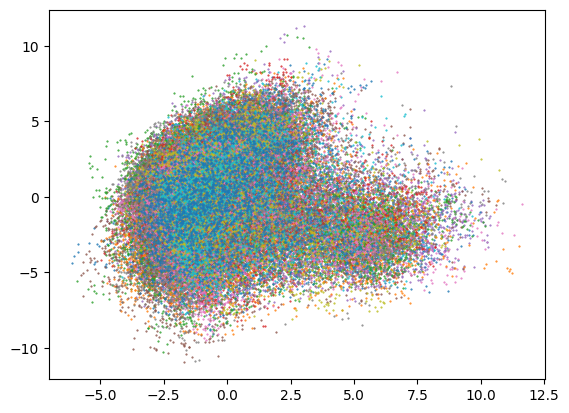

In [8]:
dim = opts.nr_ceps

# PCA reduction to 2 dimensions
cov_tot = np.cov(np.vstack(list(y2x_train_limited.values())).T, bias=True)
# take just 2 largest eigenvalues and corresponding eigenvectors
d, e = scipy.linalg.eigh(cov_tot, subset_by_index=(dim-2, dim-1))

pca_reduced = {}
for label, frames in y2x_train_limited.items():
    pca = frames.dot(e)
    pca_reduced[label] = pca
    plt.plot(pca[:,0], pca[:,1], '.', ms=1)
plt.show()

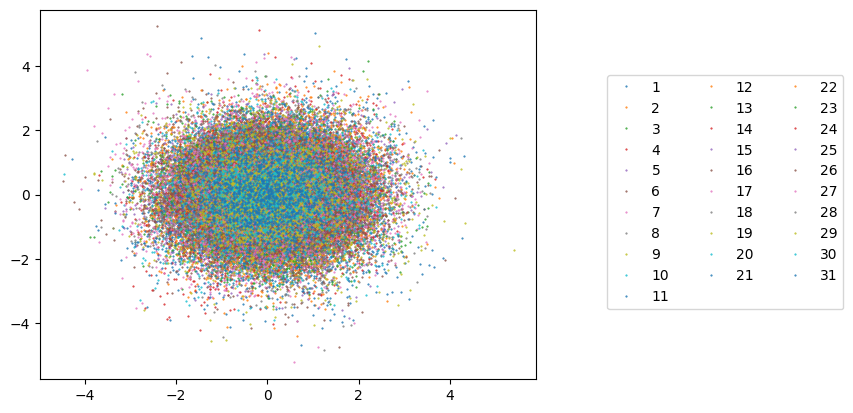

In [9]:
# LDA reduction to 2 dimensions
counts = {}
n_all = 0
cov_wc = np.zeros((dim, dim))
for label, frames in y2x_train_limited.items():
    n_label = len(frames)
    counts[label] = n_label
    n_all += n_label
    cov_wc += n_label * np.cov(frames.T, bias=True)
cov_wc /= n_all
cov_ac = cov_tot - cov_wc
d, e = scipy.linalg.eigh(cov_ac, cov_wc, subset_by_index=(dim-2, dim-1))

fig = plt.figure()
lda_reduced = {}
for label, frames in sorted(y2x_train_limited.items()):
    lda = frames.dot(e)
    lda_reduced[label] = lda
    plt.plot(lda[:,0], lda[:,1], ".", ms=1, label=label)
fig.legend(ncol=3, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

y2x_train_limited_lda2 = group_features_by_label(lda_reduced.values(), lda_reduced.keys(), concatenate=True)

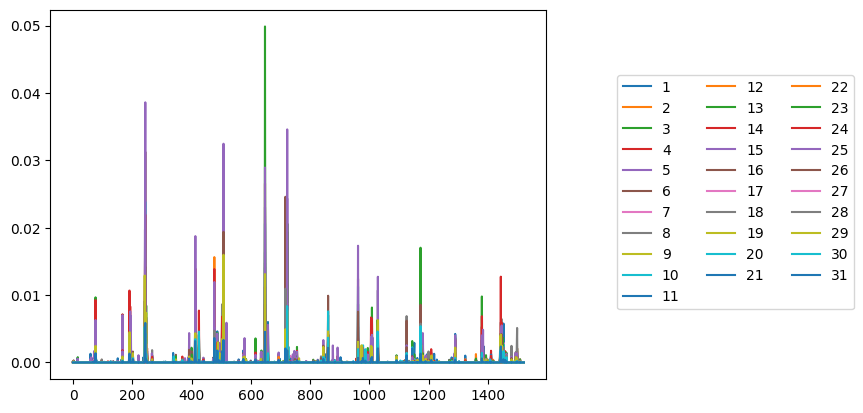

In [10]:
# Assume unified apriori. The frame count for each class was balanced above, so why not.
priors = {label: 1 / nr_classes for label in range(1, nr_classes + 1)}

# For one male test utterance (test_m[0]), obtain frame-by-frame log-likelihoods
# with two models, one trained using male and second using feamle training data.
# In this case, the models are single gaussians with diagonal covariance matrices.
sample = x_val[0]
ll_label = {}
for label, frames in y2x_train_limited.items():
    #ll_label[label] = logpdf_gauss(sample, np.mean(frames, axis=0), np.var(frames, axis=0))
    ll_label[label] = logpdf_gauss(sample, *train_gauss(frames))

# Plot the frame-by-frame likelihoods. Note that 'll_label' are log likelihoods, so we need to use exp().
fig = plt.figure()
for label, ll in sorted(ll_label.items()):
    plt.plot(np.exp(ll), label=label)
fig.legend(ncol=3, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

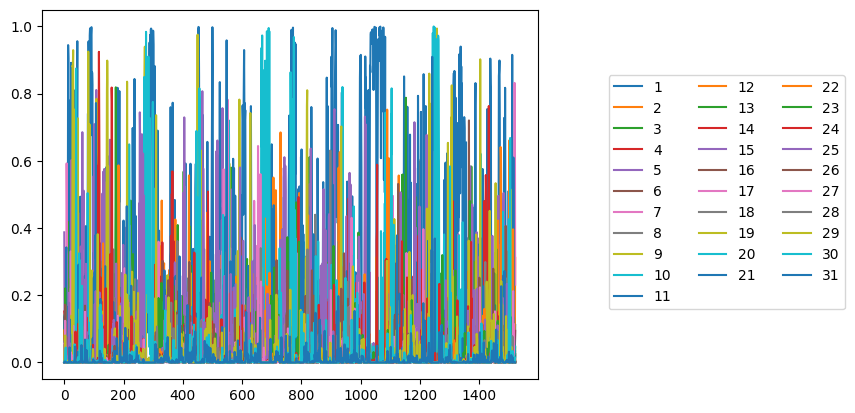

In [11]:
# Plot frame-by-frame posteriors.
# Alternatively the posterior can by computed using log odds ratio and logistic sigmoid function as:
# posterior_m = logistic_sigmoid(ll_m - ll_f + log(P_m/P_f));

evidence = 0
joint = {}
for label, ll in sorted(ll_label.items()):
    prior = priors[label]
    p_joint_x_label = np.exp(ll) * prior
    joint[label] = p_joint_x_label
    evidence += p_joint_x_label

fig = plt.figure()
for label, ll in sorted(ll_label.items()):
    posterior_label = joint[label] / evidence
    plt.plot(posterior_label, label=label)
fig.legend(ncol=3, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

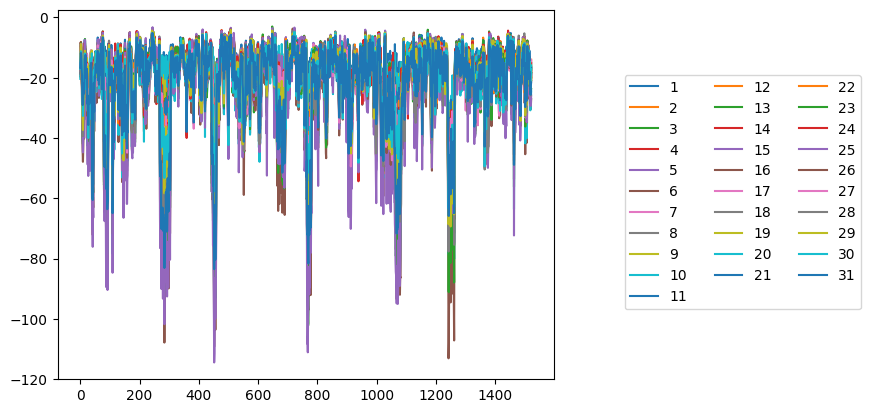

In [12]:
# Plot frame-by-frame log-likelihoods
fig = plt.figure()
for label, ll in sorted(ll_label.items()):
    plt.plot(ll, label=label)
fig.legend(ncol=3, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
# But, we do not want to make frame-by-frame decisions. We want to recognize the
# whole segment. Aplying frame independeny assumption, we sum log-likelihoods.
# We decide for label 'l' if the following quantity is the largest from all.
log_joint_frames = {}
posterior_joint_frames = {}
for label, ll in sorted(ll_label.items()):
    prior = priors[label]
    log_joint_frames_label = np.sum(ll) + np.log(prior)
    log_joint_frames[label] = log_joint_frames_label
decision_idx = np.array(list(log_joint_frames.values())).argmax()
decision = list(log_joint_frames.items())[decision_idx]
print(*decision)

1 -21422.875545951185


In [14]:
params_label = {}
for label, frames in y2x_train_limited.items():
    #params = np.mean(frames, axis=0), np.var(frames, axis=0)
    params = train_gauss(frames)
    params_label[label] = params

scores = []
decisions = []
for sample in x_val:
    log_joint_frames = {}
    for label in y2x_train_limited.keys():
        ll_label = logpdf_gauss(sample, *params_label[label])
        log_joint_frames_label = np.sum(ll_label) + np.log(priors[label])
        log_joint_frames[label] = log_joint_frames_label
    scores.append(log_joint_frames)
    decision_idx = np.array(list(log_joint_frames.values())).argmax()
    decision = list(log_joint_frames.items())[decision_idx]
    decisions.append(decision)
decisions_labels = np.array([label for label, log_joint in decisions])
print_result(decisions_labels, gt=gt)

56 out of 62 (90%)


In [15]:
# Run recognition with LDA projected data
d_full, e_full = scipy.linalg.eigh(cov_ac, cov_wc)

lda_transformed = {}
for label, frames in sorted(y2x_train_limited.items()):
    lda = frames.dot(e_full)
    lda_transformed[label] = lda
y2x_train_limited_lda_full = group_features_by_label(lda_transformed.values(), lda_transformed.keys(), concatenate=True)

params_lda_label = {}
for label, frames in y2x_train_limited_lda_full.items():
    #params = np.mean(frames, axis=0), np.var(frames, axis=0)
    params = train_gauss(frames)
    params_lda_label[label] = params

scores_lda = []
decisions_lda = []
for sample in x_val:
    log_joint_frames = {}
    for label in y2x_train_limited_lda_full.keys():
        ll_label = logpdf_gauss(sample.dot(e_full), *params_lda_label[label])
        log_joint_frames_label = np.sum(ll_label) + np.log(priors[label])
        log_joint_frames[label] = log_joint_frames_label
    scores_lda.append(log_joint_frames)
    decision_idx = np.array(list(log_joint_frames.values())).argmax()
    decision = list(log_joint_frames.items())[decision_idx]
    decisions_lda.append(decision)
decisions_lda_labels = np.array([label for label, log_joint in decisions_lda])
print_result(decisions_lda_labels, gt=gt)

56 out of 62 (90%)


In [16]:
# Train and test with GMM models with diagonal/full covariance matrices
# Decide for number of gaussian mixture components used for every label
k = 2

# Initialize mean vectors, covariance matrices and weights of mixture componments
# Initialize mean vectors to randomly selected data points from corresponding class
# Initialize all variance vectors (diagonals of the full covariance matrices) to
# the same variance vector computed using all the data from the given class
# Use uniform distribution as initial guess for the weights
gmm_params = {}
for label, frames in y2x_train_limited_lda_full.items():
    ws = np.ones(k) / k
    mus = opts.rng.choice(frames, size=k, replace=False, p=None, axis=0, shuffle=True)
    #covs = [np.var(frames, axis=0)] * k
    covs = [np.cov(frames.T, bias=True)] * k
    gmm_params[label] = ws, mus, covs

# Run iterations of EM algorithm to train GMMs
total_ll = {label: list() for label in range(1, nr_classes + 1)}
for jj in range(100):
    for label, frames in y2x_train_limited_lda_full.items():
        [ws, mus, covs, tll] = train_gmm(frames, *gmm_params[label])
        gmm_params[label] = ws, mus, covs
        total_ll[label].append(tll)

# Now run recognition for all test utterances
scores = []
decisions = []
for sample in x_val:
    log_joint_frames = {}
    for label in y2x_train_limited.keys():
        ll_label = logpdf_gmm(sample.dot(e_full), *gmm_params[label])
        log_joint_frames_label = np.sum(ll_label) + np.log(priors[label])
        log_joint_frames[label] = log_joint_frames_label
    scores.append(np.array([v for k, v in sorted(log_joint_frames.items())]))
    decision_idx = np.array(list(log_joint_frames.values())).argmax()
    decision = list(log_joint_frames.items())[decision_idx]
    decisions.append(decision)
#print(decisions)
decisions_labels = np.array([label for label, log_joint in decisions])
print_result(decisions_labels, gt=gt)

59 out of 62 (95%)


In [ ]:
dl_test = setup_test_loader(data_dir="data/eval", batch_size=16, shuffle=False)
x_test, segments = get_features_labels(dl_test, opts, segments=True)

scores = []
decisions = []
for sample in x_test:
    log_joint_frames = {}
    for label in y2x_train_limited.keys():
        ll_label = logpdf_gmm(sample.dot(e_full), *gmm_params[label])
        log_joint_frames_label = np.sum(ll_label) + np.log(priors[label])
        log_joint_frames[label] = log_joint_frames_label
    scores.append(np.array([v for k, v in sorted(log_joint_frames.items())]))
    decision_idx = np.array(list(log_joint_frames.values())).argmax()
    decision = list(log_joint_frames.items())[decision_idx]
    decisions.append(decision)
decisions_labels = np.array([label for label, log_joint in decisions])

write_results(Path("results_gmm.txt"), scores, segments, opts, is_score=True)